# Big Data Analytics Final Project Airlines Dataset
Names: Mark Stiles, Kelsey Kirby, Gianni Conde

# **Libraries**

In [1]:
! pip install pyspark -q

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 317.3/317.3 MB 3.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done


In [2]:
import io
import pandas as pd
import numpy as np
import seaborn as sns
import time
from timeit import default_timer as timer
from pyspark.sql.functions import col,isnan,when,count
from datetime import timedelta
from string import Formatter
import matplotlib.pyplot as plt
from datetime import datetime, timedelta
from pyspark import SparkContext
from pyspark.sql import SparkSession
from pyspark.sql import functions as fn
from pyspark.sql.types import StringType, FloatType, StructType, IntegerType
from pyspark.ml.classification import LogisticRegression
from pyspark.ml.classification import RandomForestClassifier
from pyspark.ml.classification import DecisionTreeClassifier
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder
from pyspark.ml.classification import GBTClassifier
from pyspark.ml.classification import NaiveBayes
from pyspark.ml.classification import LinearSVC
from pyspark.ml.evaluation import BinaryClassificationEvaluator
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.feature import PCA
from pyspark.ml.feature import StandardScaler
from pyspark.ml.feature import MinMaxScaler
from pyspark.ml.feature import StringIndexer
from pyspark.ml.feature import Normalizer
from pyspark.ml.feature import OneHotEncoder
from pyspark.ml import Pipeline
#import pyspark.pandas as ps
#from pyspark.sql.types import StringType
#from pyspark.sql.functions import udf
import pyspark.sql.functions as f
from pyspark.sql import types
import numpy as np

# **Global Functions**

In [3]:
# Print the timestamp now compared to a start time and leave a message
def PrintTimestamp(start_time, message):
  now_time = timer()
  tdelta = timedelta(seconds=now_time-start_time)
  remainder = int(tdelta.total_seconds())

  fmt='{D:02}d {H:02}h {M:02}m {S:02}s'
  f = Formatter()
  desired_fields = [field_tuple[1] for field_tuple in f.parse(fmt)]

  possible_fields = ('W', 'D', 'H', 'M', 'S')
  constants = {'W': 604800, 'D': 86400, 'H': 3600, 'M': 60, 'S': 1}
  values = {}
  for field in possible_fields:
    if field in desired_fields and field in constants:
      values[field], remainder = divmod(remainder, constants[field])

  print(f'{f.format(fmt, **values)}: {message}')

In [4]:
def check_for_nulls(dataframe):
  null_counts = dataframe.select([count(when(col(c).contains('None') | \
            col(c).contains('NULL') | \
            (col(c) == '' ) | \
            col(c).isNull() | \
            isnan(c), c
            )).alias(c)
    for c in airlines_df.columns])
  null_counts.show()

# **Context**

In [5]:
sc = SparkContext.getOrCreate()

spark = SparkSession\
    .builder\
    .appName('Final Project: Airline Delay Data')\
    .getOrCreate()

# **Data Retrieval**

Sources:


*   https://www.kaggle.com/datasets/ulrikthygepedersen/airlines-delay
*   https://www.kaggle.com/datasets/aravindram11/list-of-us-airports

In [6]:
%%bash
if [[ ! -f airline_delay.csv ]]; then
 wget https://github.com/markstiles/us-airline-data/raw/main/airlines_delay.csv -q
fi

In [7]:
%%bash
if [[ ! -f airports.csv ]]; then
 wget https://github.com/markstiles/us-airline-data/raw/main/airports.csv -q
fi

In [8]:
airline_schema = (StructType()
  .add('Flight', FloatType(), True)
  .add('Time', FloatType(), True)
  .add('Length', FloatType(), True)
  .add('Airline', StringType(), True)
  .add('AirportFrom', StringType(), True)
  .add('AirportTo', StringType(), True)
  .add('DayOfWeek', IntegerType(), True)
  .add('Class', IntegerType(), True)
)
airlines_df = spark.read.csv('airlines_delay.csv', header = True, schema=airline_schema)

def sum_col(num_one, num_two):
    return num_one + num_two

sum_col_udf = f.udf(sum_col, IntegerType())

airlines_df = airlines_df\
  .withColumn('Flight', airlines_df['Flight'].cast(IntegerType()))\
  .withColumn('Time', airlines_df['Time'].cast(IntegerType()))\
  .withColumn('Length', airlines_df['Length'].cast(IntegerType()))\
  .withColumn('ArrivalMin', sum_col_udf(col('Time'), col('Length')).cast(IntegerType()))\
  .withColumnRenamed('Time','DepartureMin')\
  .withColumnRenamed('Length','FlightMin')\
  .withColumnRenamed('AirportFrom','DepartureCode')\
  .withColumnRenamed('AirportTo','ArrivalCode')

In [9]:
print('AIRLINES')
print(f'shape({airlines_df.count()}, {len(airlines_df.columns)})')
airlines_df.printSchema()
airlines_df.show(5)

AIRLINES
shape(539382, 9)
root
 |-- Flight: integer (nullable = true)
 |-- DepartureMin: integer (nullable = true)
 |-- FlightMin: integer (nullable = true)
 |-- Airline: string (nullable = true)
 |-- DepartureCode: string (nullable = true)
 |-- ArrivalCode: string (nullable = true)
 |-- DayOfWeek: integer (nullable = true)
 |-- Class: integer (nullable = true)
 |-- ArrivalMin: integer (nullable = true)

+------+------------+---------+-------+-------------+-----------+---------+-----+----------+
|Flight|DepartureMin|FlightMin|Airline|DepartureCode|ArrivalCode|DayOfWeek|Class|ArrivalMin|
+------+------------+---------+-------+-------------+-----------+---------+-----+----------+
|  2313|        1296|      141|     DL|          ATL|        HOU|        1|    0|      1437|
|  6948|         360|      146|     OO|          COS|        ORD|        4|    0|       506|
|  1247|        1170|      143|     B6|          BOS|        CLT|        3|    0|      1313|
|    31|        1410|      344|   

In [10]:
airport_schema = (StructType()
          .add('IATA', StringType(), True)
          .add('Airport', StringType(), True)
          .add('City', StringType(), True)
          .add('State', StringType(), True)
          .add('Country', StringType(), True)
          .add('Latitude', FloatType(), True)
          .add('Longitude', FloatType(), True)
        )

def plus_180(data_value):
    return data_value + float(180)

plus_180_udf = f.udf(plus_180, FloatType())

airports_df = spark.read.csv('airports.csv', header = True, schema=airport_schema) \
  .withColumn('Longitude', plus_180_udf(col('Longitude')).cast(FloatType())) \
  .withColumnRenamed("IATA", "AirportCode") \
  .drop(col("CITY")) \
  .drop(col("COUNTRY"))

In [11]:
print('AIRPORTS')
print(f'shape({airports_df.count()}, {len(airports_df.columns)})')
airports_df.printSchema()
airports_df.show(5)

AIRPORTS
shape(341, 5)
root
 |-- AirportCode: string (nullable = true)
 |-- Airport: string (nullable = true)
 |-- State: string (nullable = true)
 |-- Latitude: float (nullable = true)
 |-- Longitude: float (nullable = true)

+-----------+--------------------+-----+---------+---------+
|AirportCode|             Airport|State| Latitude|Longitude|
+-----------+--------------------+-----+---------+---------+
|        ABQ|Albuquerque Inter...|   NM|35.040222| 73.39081|
|        ANC|Ted Stevens Ancho...|   AK| 61.17432|30.003815|
|        ATL|William B Hartsfi...|   GA|33.640446| 95.57306|
|        AUS|Austin-Bergstrom ...|   TX|30.194532| 82.33013|
|        BDL|Bradley Internati...|   CT|41.938873|107.31677|
+-----------+--------------------+-----+---------+---------+
only showing top 5 rows



In [12]:
check_for_nulls(airlines_df)

+------+------------+---------+-------+-------------+-----------+---------+-----+----------+
|Flight|DepartureMin|FlightMin|Airline|DepartureCode|ArrivalCode|DayOfWeek|Class|ArrivalMin|
+------+------------+---------+-------+-------------+-----------+---------+-----+----------+
|     0|           0|        0|      0|            0|          0|        0|    0|         0|
+------+------------+---------+-------+-------------+-----------+---------+-----+----------+



# **Feature Engineering**

## Day

In [13]:
# function to convert DayOfWeek from integers to days
def convert_days(day_num):
    day_of_week = {1:'Monday', 2:'Tuesday', 3:'Wednesday', 4:'Thursday', 5:'Friday',6:'Saturday',7:'Sunday'}
    return day_of_week.get(day_num)

In [14]:
convert_days_udf = f.udf(convert_days, types.StringType())
airlines_df = airlines_df.withColumn('Day', convert_days_udf(col('DayOfWeek')))

## Time of Day

In [15]:
# creating column representing Morning, Afternoon, Evening, Night
def time_of_day(minutes):
    # converting minutes elapsed
    time_new = timedelta(minutes=minutes)
    # pulling hours from new time data
    hour = time_new.seconds // 3600

    if 5 <= hour < 12:
                return 'Morning'
    elif 12 <= hour < 17:
                return 'Afternoon'
    elif 17 <= hour < 21:
                return 'Evening'
    else:
        return 'Night'

In [16]:
time_of_day_udf = f.udf(time_of_day, types.StringType())
airlines_df = airlines_df.withColumn('TimeOfDay', time_of_day_udf(col('DepartureMin')))

## Departure Time

In [17]:
# convert DepartureMin columns format from minutes elapsed to HH:MM
def convert_dep_time(time_value):
  return pd.to_datetime(time_value, unit='m').strftime('%H:%M')

In [18]:
convert_dep_time_udf = f.udf(convert_dep_time, types.StringType())
airlines_df = airlines_df.withColumn('DepartureTime', convert_dep_time_udf(col('DepartureMin')))

## Arrival Time

In [19]:
# convert ArrivalMin columns format from minutes elapsed to HH:MM
def convert_arr_time(time_value):
  return pd.to_datetime(time_value, unit='m').strftime('%H:%M')

In [20]:
convert_arr_time_udf = f.udf(convert_arr_time, types.StringType())
airlines_df = airlines_df.withColumn('ArrivalTime', convert_arr_time_udf(col('ArrivalMin')))

## Airline

In [21]:
print('Unique airlines:')
al_list = airlines_df.select("Airline").distinct().collect()
unique_al_list = [al['Airline'] for al in al_list]
print(unique_al_list)

Unique airlines:
['UA', 'AA', 'EV', 'B6', 'DL', 'OO', 'F9', 'YV', 'US', 'MQ', 'OH', 'HA', 'XE', 'AS', 'FL', 'CO', 'WN', '9E']


In [22]:
# convert Airline abbreviations with their true names
def convert_airline(airline_code):
    airline_map = {'DL':'Delta Airlines','OO':'SkyWest Airlines','B6':'JetBlue','US':'US Airways',
               'FL':'AirTran Airways','WN':'Southwest Airlines','CO':'Continental Airlines',
               'AA':'American Airlines','YV':'Mesa','EV':'ExpressJet Airlines','XE':'JetSuiteX',
               '9E':'Endeavor Air','OH':'PSA Airlines','UA':'United Airlines','MQ':'Envoy Air',
               'AS':'Alaska Airlines','F9':'Frontier Airlines','HA':'Hawaiian Airlines'}
    return airline_map.get(airline_code)

In [23]:
convert_airline_udf = f.udf(convert_airline, types.StringType())
airlines_df = airlines_df.withColumn('Airline', convert_airline_udf(col('Airline')))

## Departure and Arrival

In [24]:
# unique values from both Departure and Arrival
dep_list = airlines_df.select('DepartureCode').distinct().collect()
unique_dep_list = [dep['DepartureCode'] for dep in dep_list]

arr_list = airlines_df.select('ArrivalCode').distinct().collect()
unique_arr_list = [arr['ArrivalCode'] for arr in arr_list]

both = np.unique(np.concatenate((unique_dep_list, unique_arr_list)))
print('Unique airport codes:')
print(both)

Unique airport codes:
['ABE' 'ABI' 'ABQ' 'ABR' 'ABY' 'ACT' 'ACV' 'ACY' 'ADK' 'ADQ' 'AEX' 'AGS'
 'ALB' 'AMA' 'ANC' 'ASE' 'ATL' 'ATW' 'AUS' 'AVL' 'AVP' 'AZO' 'BDL' 'BET'
 'BFL' 'BGM' 'BGR' 'BHM' 'BIL' 'BIS' 'BKG' 'BLI' 'BMI' 'BNA' 'BOI' 'BOS'
 'BQK' 'BQN' 'BRO' 'BRW' 'BTM' 'BTR' 'BTV' 'BUF' 'BUR' 'BWI' 'BZN' 'CAE'
 'CAK' 'CDC' 'CDV' 'CEC' 'CHA' 'CHO' 'CHS' 'CIC' 'CID' 'CLD' 'CLE' 'CLL'
 'CLT' 'CMH' 'CMI' 'CMX' 'COD' 'COS' 'COU' 'CPR' 'CRP' 'CRW' 'CSG' 'CVG'
 'CWA' 'CYS' 'DAB' 'DAL' 'DAY' 'DBQ' 'DCA' 'DEN' 'DFW' 'DHN' 'DLH' 'DRO'
 'DSM' 'DTW' 'EAU' 'ECP' 'EGE' 'EKO' 'ELM' 'ELP' 'ERI' 'EUG' 'EVV' 'EWN'
 'EWR' 'EYW' 'FAI' 'FAR' 'FAT' 'FAY' 'FCA' 'FLG' 'FLL' 'FLO' 'FNT' 'FSD'
 'FSM' 'FWA' 'GCC' 'GEG' 'GFK' 'GGG' 'GJT' 'GNV' 'GPT' 'GRB' 'GRK' 'GRR'
 'GSO' 'GSP' 'GTF' 'GTR' 'GUC' 'GUM' 'HDN' 'HLN' 'HNL' 'HOU' 'HPN' 'HRL'
 'HSV' 'HTS' 'IAD' 'IAH' 'ICT' 'IDA' 'ILM' 'IND' 'IPL' 'ISP' 'ITH' 'ITO'
 'IYK' 'JAC' 'JAN' 'JAX' 'JFK' 'JNU' 'KOA' 'KTN' 'LAN' 'LAS' 'LAX' 'LBB'
 'LCH' 'LEX' 'LFT' 'LGA' 'LGB

In [25]:
airlines_df = airlines_df \
  .join(airports_df, airlines_df.DepartureCode == airports_df.AirportCode, 'inner') \
  .drop('AirportCode') \
  .withColumnRenamed('Airport', 'DepartureAirport') \
  .withColumnRenamed('State', 'DepartureState') \
  .withColumnRenamed('Latitude', 'DepartureLatitude') \
  .withColumnRenamed('Longitude', 'DepartureLongitude') \

airlines_df = airlines_df \
  .join(airports_df, airlines_df.ArrivalCode == airports_df.AirportCode, 'inner') \
  .drop('AirportCode') \
  .withColumnRenamed('Airport', 'ArrivalAirport') \
  .withColumnRenamed('State', 'ArrivalState') \
  .withColumnRenamed('Latitude', 'ArrivalLatitude') \
  .withColumnRenamed('Longitude', 'ArrivalLongitude')

## Flight Duration

In [26]:
# convert FlightMin columns format from minutes elapsed to HH:MM
def convert_flight_length(length_value):
  return pd.to_datetime(length_value, unit='m').strftime('%H:%M')

In [27]:
convert_length_udf = f.udf(convert_flight_length, types.StringType())
airlines_df = airlines_df.withColumn('FlightDuration', convert_length_udf(col('FlightMin')))

## Final Schema

In [28]:
print('AIRLINES')
print(f'shape({airlines_df.count()}, {len(airlines_df.columns)})')
airlines_df.printSchema()
airlines_df.show(5)

AIRLINES
shape(538066, 22)
root
 |-- Flight: integer (nullable = true)
 |-- DepartureMin: integer (nullable = true)
 |-- FlightMin: integer (nullable = true)
 |-- Airline: string (nullable = true)
 |-- DepartureCode: string (nullable = true)
 |-- ArrivalCode: string (nullable = true)
 |-- DayOfWeek: integer (nullable = true)
 |-- Class: integer (nullable = true)
 |-- ArrivalMin: integer (nullable = true)
 |-- Day: string (nullable = true)
 |-- TimeOfDay: string (nullable = true)
 |-- DepartureTime: string (nullable = true)
 |-- ArrivalTime: string (nullable = true)
 |-- DepartureAirport: string (nullable = true)
 |-- DepartureState: string (nullable = true)
 |-- DepartureLatitude: float (nullable = true)
 |-- DepartureLongitude: float (nullable = true)
 |-- ArrivalAirport: string (nullable = true)
 |-- ArrivalState: string (nullable = true)
 |-- ArrivalLatitude: float (nullable = true)
 |-- ArrivalLongitude: float (nullable = true)
 |-- FlightDuration: string (nullable = true)

+------

# **Null Checks**

In [29]:
check_for_nulls(airlines_df)

+------+------------+---------+-------+-------------+-----------+---------+-----+----------+---+---------+-------------+-----------+----------------+--------------+-----------------+------------------+--------------+------------+---------------+----------------+--------------+
|Flight|DepartureMin|FlightMin|Airline|DepartureCode|ArrivalCode|DayOfWeek|Class|ArrivalMin|Day|TimeOfDay|DepartureTime|ArrivalTime|DepartureAirport|DepartureState|DepartureLatitude|DepartureLongitude|ArrivalAirport|ArrivalState|ArrivalLatitude|ArrivalLongitude|FlightDuration|
+------+------------+---------+-------+-------------+-----------+---------+-----+----------+---+---------+-------------+-----------+----------------+--------------+-----------------+------------------+--------------+------------+---------------+----------------+--------------+
|     0|           0|        0|      0|            0|          0|        0|    0|         0|  0|        0|            0|          0|               0|             0|  

# **Airlines Dataframe Import**
This is the exported dataframe after cleaning and engineering used to prevent having to recalculate the dataset each time the runtime was changed between CPU and GPU

## Import

In [30]:
%%bash
if [[ ! -f airlines_df.csv ]]; then
 wget https://github.com/markstiles/us-airline-data/raw/main/airlines_df.csv -q
fi

In [31]:
import_schema = (StructType()
	.add('Flight', IntegerType(), True)
	.add('DepartureMin', IntegerType(), True)
	.add('FlightMin', IntegerType(), True)
	.add('Airline', StringType(), True)
	.add('DepartureCode', StringType(), True)
	.add('ArrivalCode', StringType(), True)
	.add('DayOfWeek', IntegerType(), True)
	.add('Class', IntegerType(), True)
	.add('ArrivalMin', IntegerType(), True)
	.add('Day', StringType(), True)
	.add('TimeOfDay', StringType(), True)
	.add('DepartureTime', StringType(), True)
	.add('FlightDuration', StringType(), True)
	.add('ArrivalTime', StringType(), True)
	.add('DepartureAirport', StringType(), True)
	.add('DepartureState', StringType(), True)
	.add('DepartureLatitude', FloatType(), True)
	.add('DepartureLongitude', FloatType(), True)
	.add('ArrivalAirport', StringType(), True)
	.add('ArrivalState', StringType(), True)
	.add('ArrivalLatitude', FloatType(), True)
	.add('ArrivalLongitude', FloatType(), True)
)

airlines_df = spark.read.csv('airlines_df.csv', header = True, schema=import_schema)

# **Exploratory Data Analysis**

## Distributions

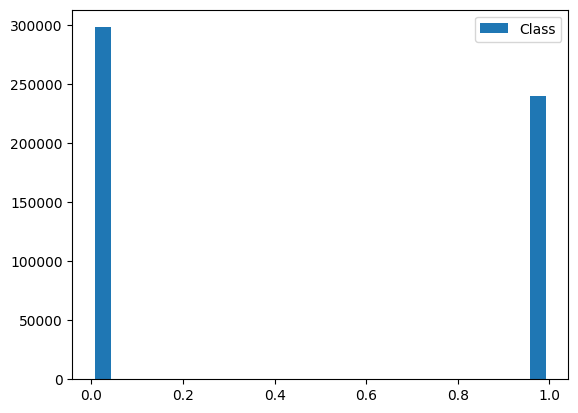

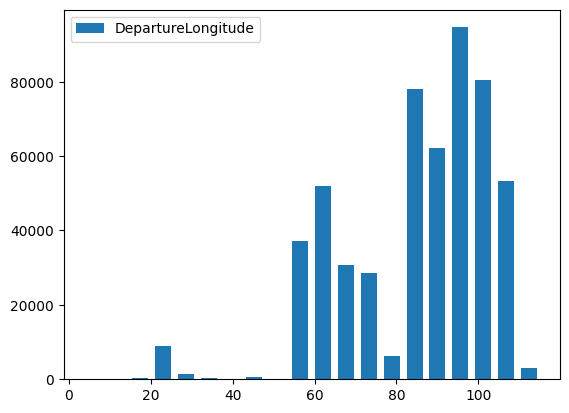

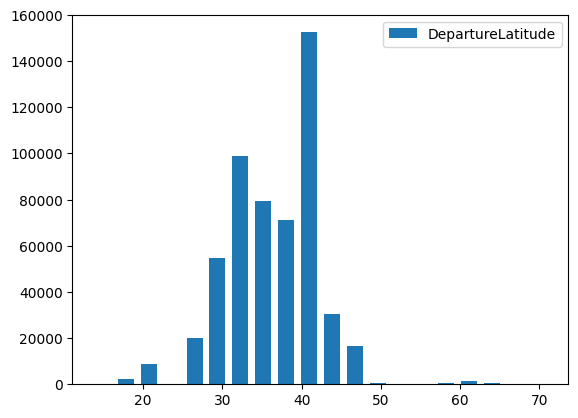

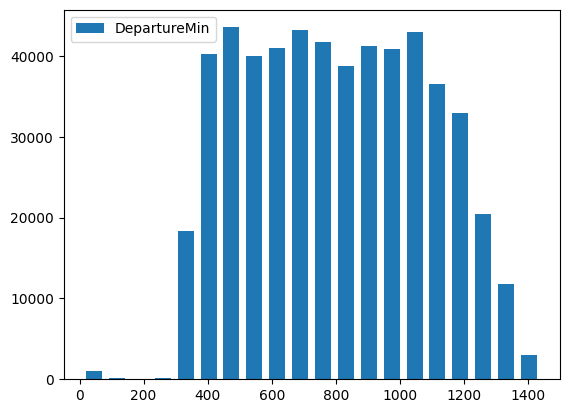

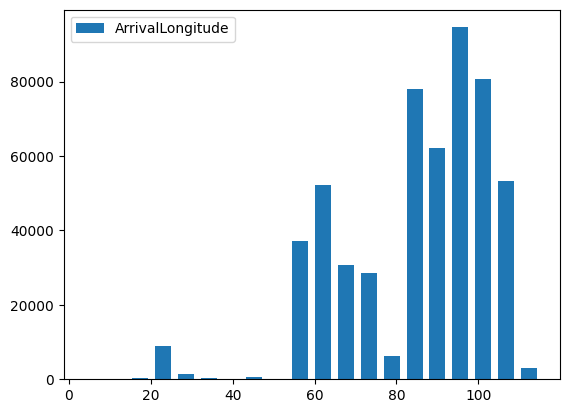

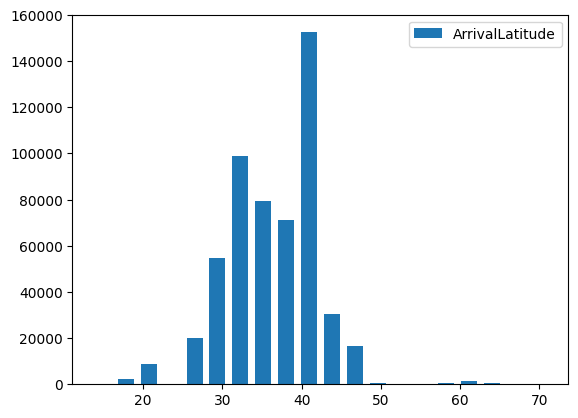

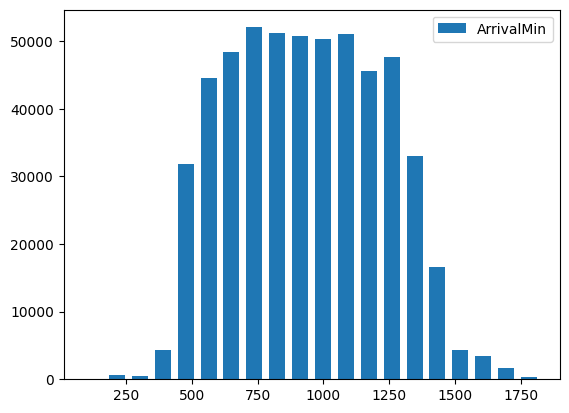

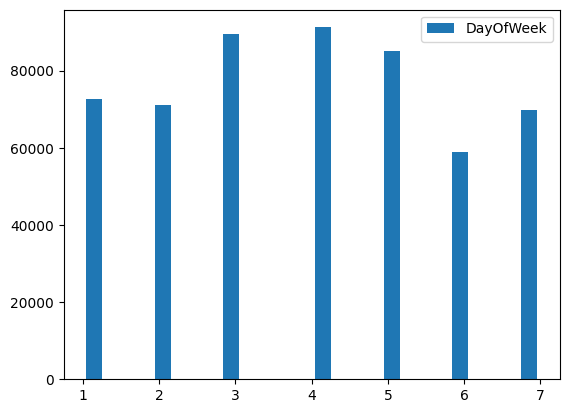

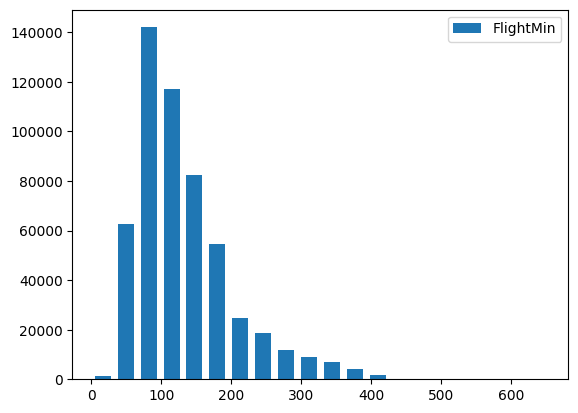

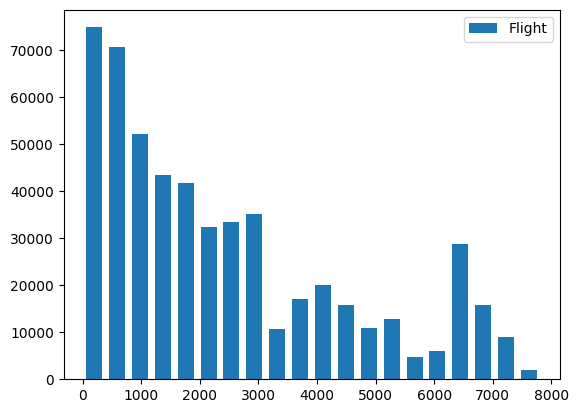

In [32]:
# numeric distributions
num_arr = ['Class', 'DepartureLongitude', 'DepartureLatitude', 'DepartureMin', 'ArrivalLongitude', 'ArrivalLatitude', 'ArrivalMin', 'DayOfWeek', 'FlightMin', 'Flight']
for numeric_category in num_arr:
  airlines_df.select(numeric_category).toPandas()\
    .plot(kind = 'hist', title='', xlabel='', ylabel='', bins=20, rwidth=0.7);

## Enumeration Barplots

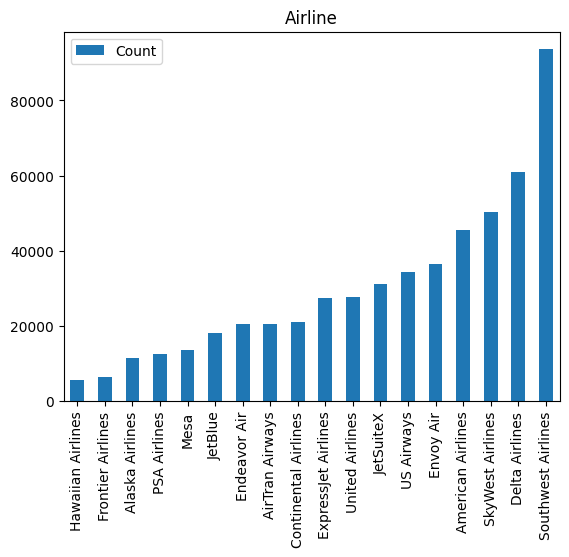

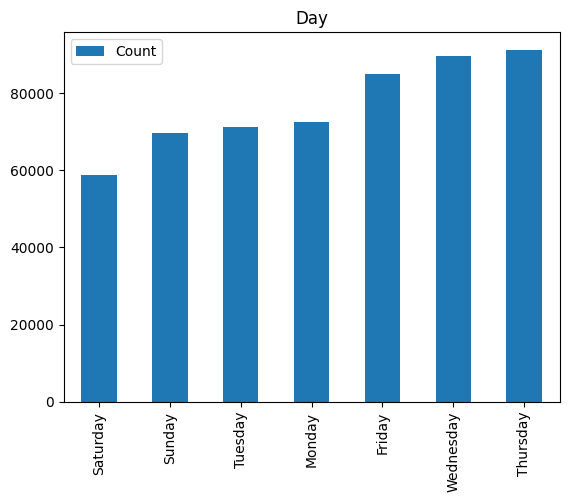

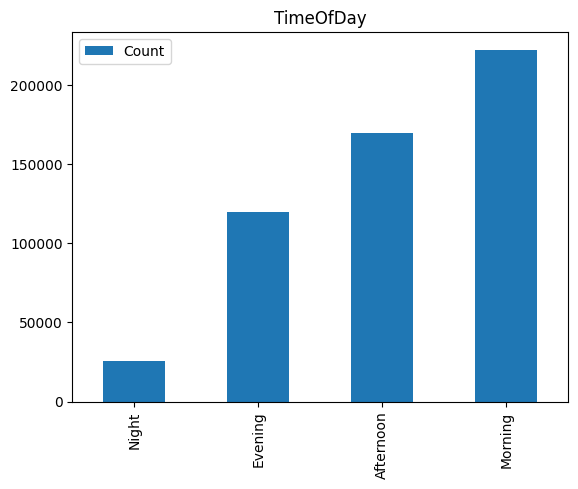

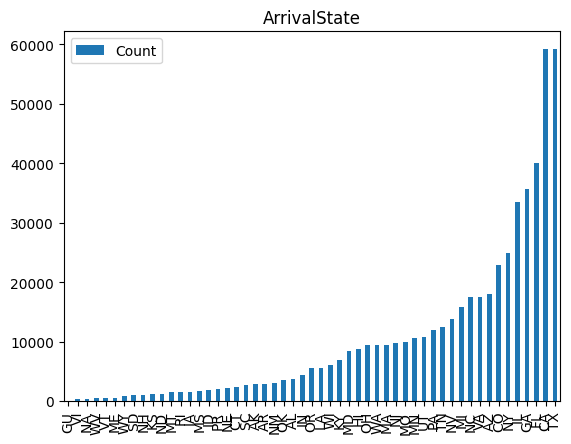

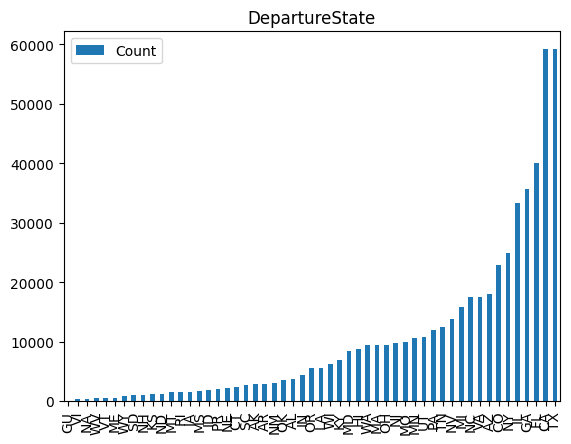

In [33]:
too_many = ['ArrivalAirport', 'DepartureAirport', 'ArrivalTime', 'FlightDuration', 'DepartureTime']
cat_arr = ['Airline', 'Day', 'TimeOfDay', 'ArrivalState', 'DepartureState']
for category in cat_arr:
    count_label = 'Count'
    airlines_df \
      .groupBy(category) \
      .agg(fn.count(category).alias(count_label)) \
      .select(category, count_label) \
      .orderBy(count_label) \
      .toPandas() \
      .plot(kind = 'bar', x=category, y=count_label, title=category, xlabel='', ylabel='')

## Pairs Plot

00d 00h 00m 07s: DepartureLongitude x DepartureLongitude - row:0;col:0
00d 00h 00m 07s: DepartureLongitude x DepartureLatitude - row:0;col:1
00d 00h 00m 10s: DepartureLongitude x DepartureMin - row:0;col:2
00d 00h 00m 14s: DepartureLongitude x ArrivalLongitude - row:0;col:3
00d 00h 00m 19s: DepartureLongitude x ArrivalLatitude - row:0;col:4
00d 00h 00m 23s: DepartureLongitude x ArrivalMin - row:0;col:5
00d 00h 00m 27s: DepartureLongitude x DayOfWeek - row:0;col:6
00d 00h 00m 30s: DepartureLongitude x FlightMin - row:0;col:7
00d 00h 00m 38s: DepartureLatitude x DepartureLongitude - row:1;col:0
00d 00h 00m 42s: DepartureLatitude x DepartureLatitude - row:1;col:1
00d 00h 00m 42s: DepartureLatitude x DepartureMin - row:1;col:2
00d 00h 00m 47s: DepartureLatitude x ArrivalLongitude - row:1;col:3
00d 00h 00m 51s: DepartureLatitude x ArrivalLatitude - row:1;col:4
00d 00h 00m 54s: DepartureLatitude x ArrivalMin - row:1;col:5
00d 00h 00m 58s: DepartureLatitude x DayOfWeek - row:1;col:6
00d 00h 0

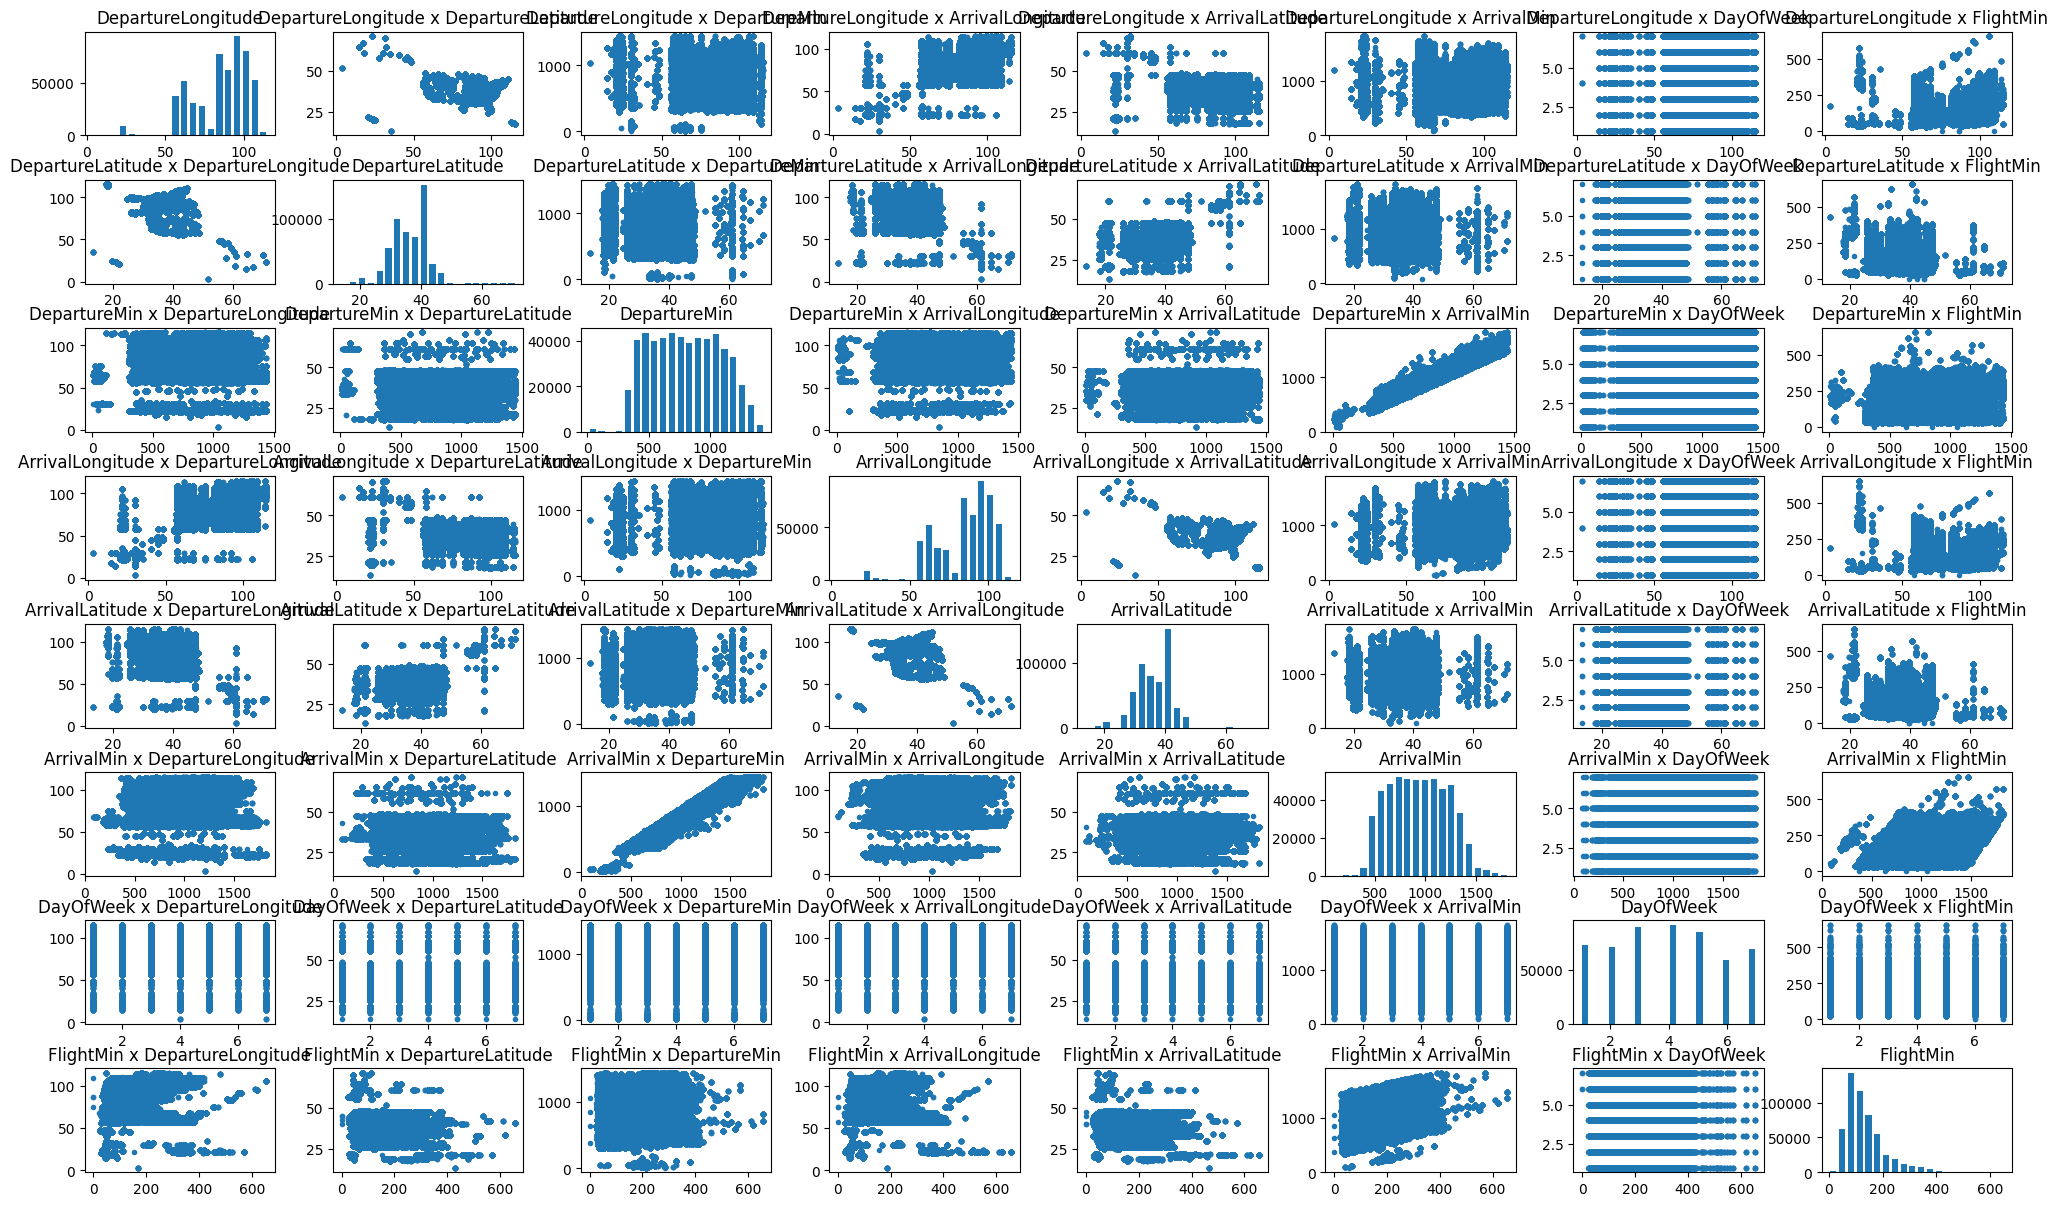

In [34]:
pair_time = timer()

pair_arr = ['DepartureLongitude', 'DepartureLatitude', 'DepartureMin', 'ArrivalLongitude', 'ArrivalLatitude', 'ArrivalMin', 'DayOfWeek', 'FlightMin']
pair_len = len(pair_arr)

fig, ax = plt.subplots(pair_len,pair_len)
fig.set_figwidth(20)
fig.set_figheight(12)
fig.tight_layout()

pair_row = 0
for col in pair_arr:
  pair_col = 0
  temp_col = airlines_df.select(col).toPandas()[col]

  for col2 in pair_arr:
    PrintTimestamp(pair_time, f'{col} x {col2} - row:{pair_row};col:{pair_col}')
    cur_ax = ax[pair_row,pair_col]
    if(col == col2):
      cur_ax.hist(temp_col, bins=20, rwidth=0.7)
      cur_ax.set_title(col)
    else:
      temp_col2 = airlines_df.select(col2).toPandas()[col2]
      cur_ax.scatter(temp_col, temp_col2, marker=".")
      cur_ax.set_title(f'{col} x {col2}')
    pair_col += 1
  pair_row += 1

PrintTimestamp(pair_time, f'Finished Pairs Plot')

## Flight Density Map

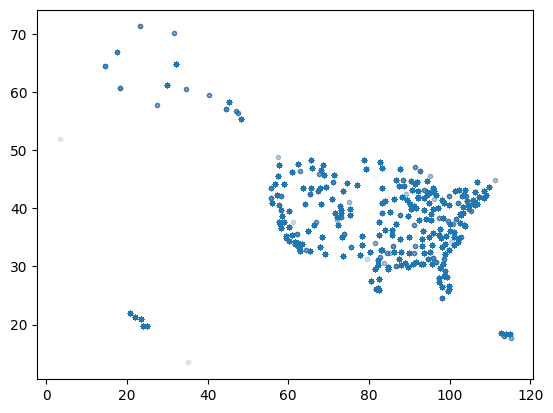

In [35]:
col = 'DepartureLongitude'
col_label = 'DepLongSum'

col2 = 'DepartureLatitude'
col2_label = 'DepLatSum'

col3 = 'DepartureMin'
col3_label = 'DepMinAvg'

temp_df = airlines_df.select(col, col2, col3).toPandas()
plt.scatter(temp_df[col], temp_df[col2], marker=".", alpha=0.01)

# **Principal Component Analysis**

In [36]:
pca_time = timer()

# build the model pipe
pca_pipe = Pipeline(stages = [
  VectorAssembler(
    inputCols = ['DepartureMin', 'FlightMin', 'DayOfWeek', 'ArrivalLatitude', 'ArrivalLongitude', 'DepartureLatitude', 'DepartureLongitude'],
    outputCol='features_pre', handleInvalid="skip"),
  StandardScaler(inputCol='features_pre', outputCol='features', withMean = True, withStd = False),
  PCA(k=7, inputCol='features', outputCol='scores')
])

# split train/test data
pca_train_set, pca_test_set = airlines_df.sample(fraction=1.0).limit(10000).randomSplit([0.8, 0.2], seed = 1980)

print(f'*** PCA ***')
print()

print(f'{pca_train_set.count()} observations')

PrintTimestamp(pca_time, f'Train start')

# fit the model
pca_model = pca_pipe.fit(pca_train_set)

PrintTimestamp(pca_time, f'Analysis Start')

explained_var = pca_model.stages[-1].explainedVariance

print(f'Explained Variance: {explained_var}')

pc_values = pca_model.stages[-1].pc.toArray()

print(f'PC: {pc_values}')

PrintTimestamp(pca_time, f'Analysis end')

*** PCA ***

7931 observations
00d 00h 00m 01s: Train start
00d 00h 00m 06s: Analysis Start
Explained Variance: [0.9390997003029774,0.052695386864434625,0.006268194292489267,0.001118148335124956,0.0005202231915797348,0.00025644737117982644,4.1899642214106886e-05]
PC: [[-9.99980036e-01 -6.00198805e-03 -1.47196425e-03 -6.18342533e-04
   6.08213527e-04 -9.91739351e-04  2.44092643e-05]
 [ 6.02307324e-03 -9.99847053e-01 -8.52708608e-03 -1.39843307e-02
  -3.98893987e-04 -9.20825402e-04  5.59297780e-04]
 [-1.24099363e-05 -5.52483642e-04 -6.76267312e-04  3.17055284e-04
   1.75749762e-03 -6.87138683e-03 -9.99974416e-01]
 [-2.65673021e-04  2.17167887e-04 -2.21937381e-02 -7.03308636e-02
   6.59734071e-01  7.47860917e-01 -3.98686916e-03]
 [ 1.40782889e-03  1.60317734e-02 -6.91206911e-01 -7.19237945e-01
  -3.07350937e-02 -6.10392026e-02  5.95950051e-04]
 [ 1.11578725e-03 -1.26884031e-04 -2.25561868e-02  4.54956584e-02
   7.50731602e-01 -6.58625575e-01  5.87496532e-03]
 [ 5.93163091e-04 -3.52985067e

Text(0.5, 1.0, 'Cumulative Sum of Variance Explained')

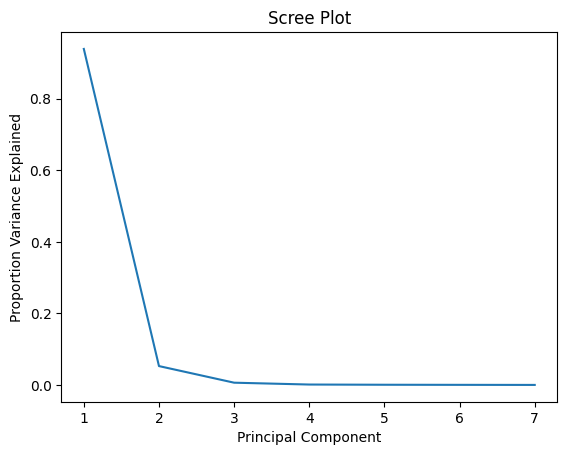

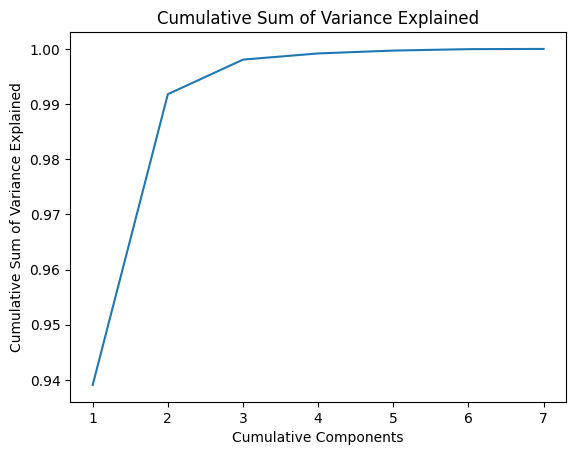

In [37]:
plt.figure()
plt.plot(np.arange(1, len(explained_var) + 1), explained_var)
plt.title('Scree Plot')
plt.xlabel('Principal Component')
plt.ylabel('Proportion Variance Explained')

cum_sum = np.cumsum(explained_var)
plt.figure()
plt.plot(np.arange(1, len(explained_var)+1), cum_sum)
plt.ylabel('Cumulative Sum of Variance Explained')
plt.xlabel('Cumulative Components')
plt.title('Cumulative Sum of Variance Explained')


In [38]:
# ensure the features aren't correlated

from pyspark.ml.stat import *

# use the numeric columns to measure correlations
num_cols = ['DepartureMin', 'FlightMin', 'DayOfWeek', 'ArrivalLatitude', 'ArrivalLongitude', 'DepartureLatitude', 'DepartureLongitude']
for col_1 in num_cols:
  for col_2 in num_cols:
    if (col_1 == col_2):
      continue

    p_corr = airlines_df.corr(col_1, col_2, 'pearson')
    if abs(p_corr) < 0.5:
      continue

    corr_sign = 'positive' if p_corr >= 0 else 'negative'

    # print the correlation value
    print(f'The pearson correlation between \'{col_1}\' and \'{col_2}\' is strong and {corr_sign} with a magnitude of {p_corr}')

The pearson correlation between 'ArrivalLongitude' and 'DepartureLongitude' is strong and positive with a magnitude of 0.6609126933649047
The pearson correlation between 'DepartureLongitude' and 'ArrivalLongitude' is strong and positive with a magnitude of 0.6609126933649047


# **Pipeline Model**

## Functions

In [39]:
# Calculate and print the 'Area Under Curve'
def PrintAUC(evaluator, prediction_set):
  log_auc = evaluator.evaluate(prediction_set)

  print(f'Test AUC score: {log_auc:.1%}')

In [40]:
# Get the best model hyperparameters and print the details
def PrintModelDetails(cv_model):
  best_model = cv_model.bestModel.stages[-1]
  bestParams = best_model.extractParamMap()
  usedParams = ['maxDepth', 'stepSize', 'maxIter', 'subsamplingRate']

  print('The best model parameters were:')
  for x in bestParams.keys():
    if(x.name in usedParams):
      print(f'    {x.name}: {bestParams[x]}')

In [41]:
# Calculate and print the 'Accuracy'
def PrintAccuracy(prediction_set):
  predicted_values = [row['prediction'] for row in prediction_set.collect()]
  actual_values = [row['Class'] for row in prediction_set.collect()]
  correct_predictions = [int(pred == true) for pred, true in zip(predicted_values, actual_values)]

  print(f'Accuracy: {(sum(correct_predictions) / len(correct_predictions)):.0%}')

## Model Pipeline

In [42]:
def TrainModel(algorithm, param_grid):

  start_time = timer()

  # create stage list
  stages = [
    StringIndexer(
      inputCols=['Airline', 'TimeOfDay', 'DepartureState'],
      outputCols=['Airline_indexed', 'TimeOfDay_indexed', 'DepartureState_indexed'],
      handleInvalid='skip'),
    OneHotEncoder(
      inputCols=['Airline_indexed', 'TimeOfDay_indexed', 'DayOfWeek'],
      outputCols=['Airline_ohe', 'TimeOfDay_ohe', 'DayOfWeek_ohe']),
    VectorAssembler(
      inputCols = ['DepartureMin', 'FlightMin', 'Airline_ohe'],
      outputCol='features_assembled'),
    StandardScaler(inputCol='features_assembled', outputCol='features')
  ]

  # join default and custom stages
  all_stages = stages + [algorithm]

  # build the model pipe
  pipe = Pipeline(stages = all_stages)

  # split train/test data
  #train_set, test_set = airlines_df.sample(fraction=1.0).limit(100000).randomSplit([0.8, 0.2], seed = 1980)
  train_set, test_set = airlines_df.randomSplit([0.8, 0.2], seed = 1980)

  print(f'*** {type(algorithm).__name__} ***')
  print()

  print(f'{train_set.count()} observations')

  PrintTimestamp(start_time, f'Buid Pipeline and Cross Validator')

  # crossvalidator
  eval = BinaryClassificationEvaluator(rawPredictionCol='prediction', labelCol='Class')
  cv = CrossValidator(estimator=pipe, estimatorParamMaps=param_grid, evaluator=eval, parallelism=2, numFolds=3)

  PrintTimestamp(start_time, f'Train start')

  # fit the model
  model = cv.fit(train_set)

  PrintTimestamp(start_time, f'Train end')

  # test the test data
  predictions = model.transform(test_set)

  PrintTimestamp(start_time, f'Predict end')

  # score results
  print()
  PrintAUC(eval, predictions)
  PrintAccuracy(predictions)

  # parameter results
  print()
  PrintModelDetails(model)

## Logistic Regression Classifier



In [43]:
lr = LogisticRegression(featuresCol='features', labelCol='Class', family="binomial")
grid = ParamGridBuilder() \
  .addGrid(lr.maxIter, [5, 10, 15]) \
  .build()

TrainModel(lr, grid)

*** LogisticRegression ***

430189 observations
00d 00h 00m 06s: Buid Pipeline and Cross Validator
00d 00h 00m 06s: Train start
00d 00h 02m 26s: Train end
00d 00h 02m 26s: Predict end

Test AUC score: 61.1%
Accuracy: 63%

The best model parameters were:
    maxIter: 10


## Naive Bayes





In [44]:
nb = NaiveBayes(featuresCol='features', labelCol='Class')
grid = ParamGridBuilder() \
  .build()

TrainModel(nb, grid)

*** NaiveBayes ***

430189 observations
00d 00h 00m 03s: Buid Pipeline and Cross Validator
00d 00h 00m 03s: Train start
00d 00h 01m 14s: Train end
00d 00h 01m 15s: Predict end

Test AUC score: 60.0%
Accuracy: 60%

The best model parameters were:


## Random Forest

In [45]:
rfc = RandomForestClassifier(featuresCol='features', labelCol='Class')

grid = ParamGridBuilder() \
  .addGrid(rfc.maxDepth, [20, 25, 30]) \
  .addGrid(rfc.subsamplingRate, [0.075, 0.1, 0.15]) \
  .build()

TrainModel(rfc, grid)

*** RandomForestClassifier ***

430189 observations
00d 00h 00m 05s: Buid Pipeline and Cross Validator
00d 00h 00m 05s: Train start
00d 00h 21m 54s: Train end
00d 00h 21m 54s: Predict end

Test AUC score: 61.7%
Accuracy: 64%

The best model parameters were:
    maxDepth: 30
    subsamplingRate: 0.1


## Gradient Boosted Tree

In [46]:
gbt = GBTClassifier(featuresCol='features', labelCol='Class', maxIter=10, maxDepth=4, stepSize=0.05, subsamplingRate=0.1)

grid = ParamGridBuilder() \
  .addGrid(gbt.maxDepth, [4, 5, 6]) \
  .addGrid(gbt.maxIter, [15, 20, 25]) \
  .addGrid(gbt.stepSize, [0.1, 0.2, 0.3]) \
  .build()

TrainModel(gbt, grid)

*** GBTClassifier ***

430189 observations
00d 00h 00m 03s: Buid Pipeline and Cross Validator
00d 00h 00m 03s: Train start
00d 00h 48m 41s: Train end
00d 00h 48m 41s: Predict end

Test AUC score: 62.1%
Accuracy: 64%

The best model parameters were:
    maxDepth: 5
    maxIter: 25
    stepSize: 0.2
    subsamplingRate: 0.1


## Decision Tree Classifier

In [47]:
dt = DecisionTreeClassifier(featuresCol='features', labelCol='Class')

grid = ParamGridBuilder() \
  .addGrid(dt.maxDepth, [20, 25, 30]) \
  .build()

TrainModel(dt, grid)

*** DecisionTreeClassifier ***

430189 observations
00d 00h 00m 04s: Buid Pipeline and Cross Validator
00d 00h 00m 04s: Train start
00d 00h 03m 45s: Train end
00d 00h 03m 45s: Predict end

Test AUC score: 63.4%
Accuracy: 65%

The best model parameters were:
    maxDepth: 30


## Support Vector Machine

In [48]:
svm = LinearSVC(featuresCol='features', labelCol='Class')

grid = ParamGridBuilder() \
  .addGrid(svm.maxIter, [1, 2, 3]) \
  .build()

TrainModel(svm, grid)

*** LinearSVC ***

430189 observations
00d 00h 00m 04s: Buid Pipeline and Cross Validator
00d 00h 00m 04s: Train start
00d 00h 01m 55s: Train end
00d 00h 01m 55s: Predict end

Test AUC score: 60.9%
Accuracy: 63%

The best model parameters were:
    maxIter: 1
